![cover](./images/cover.jpg) **Author: Juan Acosta**

## Business understanding

In recent years, the video game industry has seen a significant shift towards digital sales, with a majority of global revenue coming from digital channels. In 2022, it is estimated that over 75% of global video game revenue was generated through digital sales([source](https://www.pushsquare.com/news/2022/07/nearly-80percent-of-all-ps5-ps4-games-are-bought-digitally)), indicating a strong trend towards online purchasing and digital distribution of games. This shift towards digital sales is likely driven by a number of factors, including the increasing prevalence of high-speed internet and the convenience of being able to purchase and download games directly to a device without the need for physical copies. As the video game industry continues to evolve and technology advances, it is likely that digital sales will continue to grow in importance.

Video game recommendation systems are useful because they can help players discover new games that they might enjoy based on their past behavior and preferences. In a market where there are thousands of available games, it can be overwhelming for players to go through all of the options and find something that suits their interests. A recommendation system can help narrow down the options and suggest games that are more likely to be of interest to the user. A potential issue with recommender systems on official platform stores for digital games is that they may prioritize promoting newer games that are more profitable for the store, potentially at the expense of recommending older but high-quality games. This can lead to customers missing out on discovering older games that they might enjoy. It is important to be aware of this potential bias and to consider using other sources of recommendations in addition to the official platform store's.

## Data understanding

To build a recommendation system, I used a dataset containing reviews from over 112,000 customers on more than 7,000 different game titles, for a total of over 140,000 reviews. Using the pandas library in Python, I began by performing exploratory data analysis (EDA) on the dataset, focusing on the columns that would be used as input for the recommendation algorithm. This process involved cleaning and preprocessing the data, identifying any patterns and selecting appropriate features for the model.

Amazon reviews dataset on kaggle [here](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Digital_Video_Games_v1_00.tsv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_raw = pd.read_csv('./data/Digital_Video_Games.tsv', sep='\t', header=0, error_bad_lines=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144724 entries, 0 to 144723
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        144724 non-null  object
 1   customer_id        144724 non-null  int64 
 2   review_id          144724 non-null  object
 3   product_id         144724 non-null  object
 4   product_parent     144724 non-null  int64 
 5   product_title      144724 non-null  object
 6   product_category   144724 non-null  object
 7   star_rating        144724 non-null  int64 
 8   helpful_votes      144724 non-null  int64 
 9   total_votes        144724 non-null  int64 
 10  vine               144724 non-null  object
 11  verified_purchase  144724 non-null  object
 12  review_headline    144722 non-null  object
 13  review_body        144722 non-null  object
 14  review_date        144721 non-null  object
dtypes: int64(5), object(10)
memory usage: 16.6+ MB


In [3]:
df_raw.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          2
review_date          3
dtype: int64

### Columns
- **marketplace**: 2 letter country code of the marketplace where the review was written.
- **customer_id**: Random identifier that can be used to aggregate reviews written by a single author.
- **review_id**: The unique ID of the review.
- **productid**: The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same productid.
- **product_parent**: Random identifier that can be used to aggregate reviews for the same product.
- **product_title**: Title of the product.
- **product_category**: Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
- **star_rating**: The 1-5 star rating of the review.
- **helpful_votes**: Number of helpful votes.
- **total_votes**: Number of total votes the review received.
- **vine**: Review was written as part of the Vine program.
- **verified_purchase**: The review is on a verified purchase.
- **review_headline**: The title of the review.
- **review_body**: The review text.
- **review_date**: The date the review was written.

In [4]:
df_raw['marketplace'].unique()

array(['US'], dtype=object)

All reviews in dataset are from US customers

In [5]:
df_raw['customer_id'].nunique()

112891

112891 different customers 

In [6]:
df_raw['review_id'].nunique()

144724

Seems like there are no duplicate reviews in the set

In [7]:
df_raw['product_id'].nunique()

7939

7939 different products, but not all video games, found "Playstation Plus Subscription" in row 3, so all digitally sold products related video games, like subscriptions, seem to be included in the data set, will further look for other kind of product other than games and drop those.

In [8]:
df_raw['product_parent'].nunique()

7755

- **product_parent**: Random identifier that can be used to aggregate reviews for the same product.

seems like just another id but we have about 200 less data points in this column than product id

In [9]:
df_raw['product_title'].nunique()

6946

If i have 6946 different titles, i would expect the same amount of product_id, wonder if by droping everything that is not a game, like substriptions, would fix this discrepancy.

In [10]:
df_raw.iloc[3]['product_title']

'Playstation Plus Subscription'

It doesnt specify if the subscription is for 1, 3 or 12 months

<br>

Below i used key words to look for any products that is not a game
e.g
- Subscription
- Month
- Membership
- Card
- Network



In [11]:
def look_keyword(data, strg):
    content = data[data['product_title'].str.contains(strg)]
    print(f'Number of reviews for "{strg}" items: {len(content)} \n')
    
look_keyword(df_raw, "Subscription")    
look_keyword(df_raw, "Month")
look_keyword(df_raw, "Membership")
look_keyword(df_raw, "Card")
look_keyword(df_raw, "Network")

Number of reviews for "Subscription" items: 12137 

Number of reviews for "Month" items: 630 

Number of reviews for "Membership" items: 275 

Number of reviews for "Card" items: 21173 

Number of reviews for "Network" items: 13613 



In [12]:
df_raw['star_rating'].unique()
#games were rated in a scale of 1 to 5 stars

array([2, 5, 4, 1, 3])

In [13]:
df_raw['review_date'] = pd.to_datetime(df_raw['review_date'])
print(f'All reviews date back from {df_raw.review_date.min().year} to {df_raw.review_date.max().year}')

All reviews date back from 2006 to 2015


## Data Preparation

In [14]:
#Droping all rows that have strings: Subscription, Month, Membership,Network on the product_title column
df_raw_noSub = df_raw[df_raw["product_title"].str.contains("Subscription|Month|month|Membership|Network|Credit|Season Pass|Xbox Music Pass|Virtual Currency") == False]


Season Pass, Xbox Music Pass and Virtual Currency are some of the other kind of items on the dataset, i simply added them on the line above as i kept finding more during the process

For titles that have string 'Card' in the title, i have to be more careful since there are some game that include that on their name

In [15]:
def show_keyword(data, strg):
    """
    func just to show examples of titles with given string,
    to find any non-game items in the set
    """
    content = data[data['product_title'].str.contains(strg)]
    return content['product_title'].unique()[:10]
    
    
show_keyword(df_raw_noSub, 'Card')

array(['Xbox Live Gift Card', 'Xbox 360 Live Points Card',
       'Grand Theft Auto V Cash Cards', 'Hoyle Card Games 2012 AMR',
       'Final Fantasy XIV Online: 60 Day Time Card [Online Game Code]',
       'Hoyle Card Games  [Download]',
       'Xbox $5 Gift Card - Xbox 360 Digital Code',
       "Hoyle Kid's Card Games [Download]",
       'Legends of Solitaire: The Lost Cards [Download]',
       'Xbox $15 Gift Card (Call of Duty Ghosts:\xa0Onslaught DLC) - Xbox 360 Digital Code'],
      dtype=object)

First i will drop rows where 'Gift Card' is found, then i will proceed with other common combinations of words like 'Xbox Live' and Live Points Card

In [16]:
df_raw_noSub2 = df_raw_noSub[df_raw_noSub["product_title"].str.contains("Gift Card|Xbox Live|Live Points Card|Xbox Live Gift Card|Grand Theft Auto V Cash Cards|60 Day Time Card") == False]

show_keyword(df_raw_noSub2, 'Card')

array(['Hoyle Card Games 2012 AMR', 'Hoyle Card Games  [Download]',
       "Hoyle Kid's Card Games [Download]",
       'Legends of Solitaire: The Lost Cards [Download]',
       'Tripeaks Solitaire Multi (Tripeaks with Multiple Card-Sets and Multiple Layouts) [Download]',
       'Reel Deal Card Games 2011 [Download]',
       '2,013 Card, Mahjongg & Solitaire Games [Download]',
       'Hoyle Card Games [Mac Download]', 'Five Card Deluxe [Download]',
       "King's Collection: 6 Classic Card Games"], dtype=object)

Seems like all items left that include "card" in the title are actual games

<br>

Lets look for DLCs

In [17]:
DLC = df_raw_noSub2[df_raw_noSub2['product_title'].str.contains('DLC')]
print(f"Total number of DLCs: {DLC['product_title'].nunique()}")
print(f'Total number of DLC reviews:{len(DLC)}')

Total number of DLCs: 212
Total number of DLC reviews:1698


We have 212 different DLCs, and 1698 reviews, an original copy of the first game is required to be able to run a DLC, I will drop these too.

In [18]:
df_raw_noSub_no_DLC = df_raw_noSub2[df_raw_noSub2["product_title"].str.contains("DLC|Pack") == False]

Quantity for product id and product title still doesn't match

<br>

Some games include a substring next to the title, it describes the way buyers could access the game, for example:

`18 Wheels of Steel American Long Haul [Download]`

`18 Wheels of Steel American Long Haul [Online Game Code]`

Definitely the same game, just different "delivery" method.


In [19]:
df_raw_noSub_no_DLC[df_raw_noSub_no_DLC['product_title'].str.contains('18 Wheels of Steel American Long Haul')].head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
39224,US,36420328,R2LOZS1XJTWZNN,B004GHNG0E,614285704,18 Wheels of Steel American Long Haul [Download],Digital_Video_Games,4,0,0,N,Y,Four Stars,ok,2014-10-15
50242,US,17845931,R2TJLHZ9X7EG83,B004GHNG0E,614285704,18 Wheels of Steel American Long Haul [Download],Digital_Video_Games,4,0,0,N,Y,Four Stars,Like driving trucks.,2014-07-14
74152,US,21374226,R388BHLY4GIU5E,B00CLVZGPK,775610170,18 Wheels of Steel American Long Haul [Online ...,Digital_Video_Games,1,1,1,N,Y,"Doesn't work, no manufacturer support",The code I got does not work. Amazon referred ...,2013-12-29



<br>

The `[Download]` edition of the game, on the second row above, has a different `product_id` than its `[Online Game Code]` edition (on the 3rd row above), it's the same game but taged with different ID, `product_parent` number is also different

<br>

I find it easier to modify the name than the id number, i need to group those reviews togeter, the delivery method doesnt change the software performance, so the review for a specific version is still relevant for a different one.

<br>

At first sight, `[Instant Access]`, `[Download]`, `[Digital Code]`, `[Game Connect]` and `[Online Game Code]` seem to be the most frequent tags at the end of the games titles, if i delete those out of the title name, i could use them for the rec system instead of the id, which was my first option

In [20]:
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['product_title'].str.replace(" \[Instant Access\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Download\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Game Connect\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Online Game Code\]", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Digital Code\]", "")

<ipython-input-20-de3b04f97402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['product_title'].str.replace(" \[Instant Access\]", "")
<ipython-input-20-de3b04f97402>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" \[Download\]", "")
<ipython-input-20-de3b04f97402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

The first title (on index 0) has 'Xbox One Digital Code' in its name, will check if there are more games with this same substring, or even for a different platform other than xbox

In [21]:
#below i deleted the susbstring using same method as before
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox One Digital Code", "")

#found it for the 360 console too
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox 360 Digital Code", "")

#found ' - PS4', ' - PS3', ' - PS Vita / PS4 / PS3', ' - PS Vita'
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS Vita / PS4 / PS3", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS Vita", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS3", "")
df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - PS4", "")

<ipython-input-21-b0f23e8e230f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox One Digital Code", "")
<ipython-input-21-b0f23e8e230f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_noSub_no_DLC['clean_title'] = df_raw_noSub_no_DLC['clean_title'].str.replace(" - Xbox 360 Digital Code", "")
<ipython-input-21-b0f23e8e230f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

### Clean DF

In [22]:
#New frame with cleaned data and only columns needed
Df_clean = df_raw_noSub_no_DLC[['customer_id', 'clean_title', 'star_rating']]
#reseting index
Df_clean.reset_index(drop=True, inplace=True)

print(f'Total number of customers in dataset:{Df_clean.customer_id.nunique()}')
print(f'Total number of games in dataset:{Df_clean.clean_title.nunique()}')

Total number of customers in dataset:76853
Total number of games in dataset:6000


In [105]:
# Subsetting to remove the customers with less than 5 reviews
Df_clean_subset = Df_clean[Df_clean['customer_id'].map(Df_clean['customer_id'].value_counts()) >= 5]

print(f'Total number of customers in dataset:{Df_clean_subset.customer_id.nunique()}')
print(f'Total number of games in dataset:{Df_clean_subset.clean_title.nunique()}')
print((f'Total number of reviews/ratings in dataset:{len(Df_clean_subset)}'))

Total number of customers in dataset:1375
Total number of games in dataset:3383
Total number of reviews/ratings in dataset:12200


In [24]:
#Saving as new file
Df_clean_subset.to_csv('./data/GameRatings.csv', index=False)
Ratings = pd.read_csv('./data/GameRatings.csv')

### Preparing for modeling

In [25]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Creating reader object and loading data in new format
reader = Reader(line_format='user item rating',
                sep=',', 
                rating_scale=(1, 5))

data = Dataset.load_from_df(Ratings[['customer_id', 'clean_title', 'star_rating']], reader=reader)

# split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

print('Number of users: ', trainset.n_users)
print('Number of items: ', trainset.n_items)
print('Number of ratings: ', trainset.n_ratings)

Number of users:  1375
Number of items:  3043
Number of ratings:  9760


In [26]:
#for looking back into de meaning of each id
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

# Modeling

To build the recommendation system, I am using scikit-surprise library in Python, which includes a range of algorithms and tools for building and evaluating recommendation models. Specifically, I will be using collaborative filtering techniques to make recommendations based on the similarity of users and items.

As a first step, I will train a model using a memory-based method, which utilizes the entire dataset to make predictions. After building the initial model, I will then explore the use of a model-based approach, which involves using machine learning algorithms to learn the underlying relationships in the data and make predictions. To tune the model and find the best set of hyperparameters, I will use grid search to try different combinations of parameters and evaluate their performance using root mean squared error.


In [ ]:
from surprise.prediction_algorithms import *
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV

## KNN Baseline Model

In [28]:
KNNbaseline_model = KNNBaseline()
KNNbaseline_model.fit(trainset)

#getting predictions using testset
KNNb_predictions = KNNbaseline_model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(KNNb_predictions)
accuracy.mae(KNNb_predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3060
MAE:  0.9965


0.9965072695389573

**Cross validation**

In [29]:
KNNb_cv = cross_validate(algo = KNNbaseline_model, 
                         data = data, 
                         measures=['RMSE'], 
                         cv=5, 
                         n_jobs= -2,
                         return_train_measures=True, 
                        verbose=True)

Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2991  1.3039  1.2801  1.2995  1.3050  1.2975  0.0090  
RMSE (trainset)   0.4071  0.4020  0.4051  0.4058  0.4044  0.4049  0.0017  
Fit time          0.05    0.05    0.06    0.06    0.06    0.06    0.00    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


## Baseline model

In [109]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
base_pred = baseline.test(testset)

# Save RMSE score to variable
accuracy.rmse(base_pred)
accuracy.mae(base_pred)

RMSE: 1.7023
MAE:  1.3312


1.3312096630600092

## SVD Simple model

In [30]:
SVD_model = SVD(random_state=1)
SVD_model.fit(trainset)

#getting predictions using testset
SVD_predictions = SVD_model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_predictions)
accuracy.mae(SVD_predictions)

RMSE: 1.1973
MAE:  0.9587


0.958726958002533

RMSE  lower than KNN and baseline

**Cross validation**

In [31]:
SVD_cv = cross_validate(algo = SVD_model, 
                        data = data, 
                        measures=['RMSE'], 
                        cv=5, 
                        n_jobs=-2, 
                        verbose=True, 
                        return_train_measures=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2009  1.1820  1.1814  1.1911  1.1803  1.1871  0.0079  
RMSE (trainset)   0.8149  0.8194  0.8222  0.8214  0.8248  0.8205  0.0033  
Fit time          0.46    0.53    0.46    0.46    0.45    0.47    0.03    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


### SVD Gridsearch

In [32]:
# Setting hyperparameters around default values
SVD_grid = {'n_factors':[50, 100, 120],
           'n_epochs':[10, 20, 40],
           'lr_all':[0.002, 0.005, 0.05],
           'reg_all':[0.02, 0.1], 
           'biased':[True, False], 
           'random_state':[1]}

SVD_gs = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5)

SVD_gs.fit(data)
SVD_gs.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 102 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 225 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-2)]: Done 513 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:   45.1s finished


{'n_factors': 50,
 'n_epochs': 40,
 'lr_all': 0.005,
 'reg_all': 0.1,
 'biased': True,
 'random_state': 1}

In [33]:
# using best parameters in new model and only fiting train set
svd_1 = SVD(n_factors=50, n_epochs=40, lr_all=0.005, reg_all= .1, random_state=1)

svd_1.fit(trainset)

#getting predictions using testset
SVD_pred_1 = svd_1.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_1)
accuracy.mae(SVD_pred_1)

RMSE: 1.1755
MAE:  0.9263


0.9263225202879481

Gridsearch did improve RMSE from baseline model, will set grid arround hyperparameters given on the last search

### SVD Gridsearch 2

In [34]:
# Setting hyperparameters around default values
SVD_grid_2 = {'n_factors':[30, 40, 50, 60, 70], 
              'n_epochs':[30, 35, 40, 45, 50, 55], 
              'lr_all':[0.001, 0.003, 0.005, 0.01], 
              'reg_all':[0.02, 0.05, 0.1, 0.2], 
              'random_state':[1]}

SVD_gs_2 = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid_2, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5)

SVD_gs_2.fit(data)
SVD_gs_2.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-2)]: Done 868 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 1138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 2164 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 2400 out of 2400 | elapsed:  3.8min finished


{'n_factors': 30,
 'n_epochs': 50,
 'lr_all': 0.005,
 'reg_all': 0.2,
 'random_state': 1}

In [35]:
# using best parameters in new model and only fiting train set
svd_2 = SVD(n_factors=30, n_epochs= 50, lr_all=0.005, reg_all= 0.2, random_state=1)

svd_2.fit(trainset)

#getting predictions using testset
SVD_pred_2 = svd_2.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_2)
accuracy.mae(SVD_pred_2)

RMSE: 1.1730
MAE:  0.9222


0.9222089772718052

### SVD Gridsearch 3

In [37]:
# Setting hyperparameters around default values
SVD_grid_3 = {'n_factors':[1, 4, 7, 10, 15, 20],
           'n_epochs':[45, 46, 47, 48, 49, 50, 51, 52, 57],
           'lr_all':[0.005],
           'reg_all':[0.2], 
              'random_state':[1]}

SVD_gs_3 = GridSearchCV(algo_class = SVD, 
                      param_grid = SVD_grid_3, 
                      measures=['rmse'], 
                      n_jobs = -2, 
                      joblib_verbose = 5, 
                       cv=3)

SVD_gs_3.fit(data)
SVD_gs_3.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 162 out of 162 | elapsed:    6.9s finished


{'n_factors': 10,
 'n_epochs': 45,
 'lr_all': 0.005,
 'reg_all': 0.2,
 'random_state': 1}

In [52]:
# using best parameters in new model and only fiting train set
svd_3 = SVD(n_factors=10, n_epochs= 45, lr_all=0.005, reg_all= 0.2)

svd_3.fit(trainset)

#getting predictions using testset
SVD_pred_3 = svd_3.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVD_pred_3)
accuracy.mae(SVD_pred_3)

RMSE: 1.1718
MAE:  0.9224


0.922388414722175

In [83]:
SVD_cv3 = cross_validate(algo = svd_3, 
                        data = data, 
                        measures=['RMSE'], 
                        cv=5, 
                        n_jobs=-2, 
                        verbose=True, 
                        return_train_measures=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1812  1.1691  1.1567  1.1480  1.1813  1.1673  0.0132  
RMSE (trainset)   0.8918  0.8938  0.8984  0.8990  0.8900  0.8946  0.0036  
Fit time          0.26    0.25    0.26    0.26    0.25    0.26    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


Will move on to try a different algorithm, SVD++

## SVD++

In [66]:
# Default hyperparameters
svdpp_Model = SVDpp()

svdpp_Model.fit(trainset)

#getting predictions using testset
SVDpp_pred = svdpp_Model.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred)
accuracy.mae(SVDpp_pred)

RMSE: 1.1785
MAE:  0.9337


0.9336873414189552

### SVD++ Gridsearch

In [69]:
SVDpp_grid = {'n_factors':[1, 5, 15, 30], 
              'n_epochs':[10, 20, 40], 
              'reg_all':[0.01, 0.02, 0.05], 
             'lr_all':[0.003, 0.007, 0.01]}


SVDpp_gs = GridSearchCV(algo_class = SVDpp, 
                        param_grid = SVDpp_grid, 
                        measures=['rmse'], 
                        n_jobs = -2, 
                        cv=3, 
                        joblib_verbose = 5)


SVDpp_gs.fit(data)
SVDpp_gs.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-2)]: Done 324 out of 324 | elapsed:  1.2min finished


{'n_factors': 5, 'n_epochs': 20, 'reg_all': 0.05, 'lr_all': 0.01}

In [70]:
# Default hyperparameters
svdpp_1 = SVDpp(n_factors=5, n_epochs=20, reg_all=0.05, lr_all=0.01)

svdpp_1.fit(trainset)

#getting predictions using testset
SVDpp_pred_1 = svdpp_1.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred_1)
accuracy.mae(SVDpp_pred_1)

RMSE: 1.1745
MAE:  0.9188


0.9188277216952461

### SVD++ Gridsearch 2

In [71]:
SVDpp_grid_2 = {'n_factors':[1, 3, 5, 7, 9, 10], 
              'n_epochs':[20], 
              'reg_all':[0.02, 0.05, 0.1], 
             'lr_all':[0.007, 0.01, 0.01]}


SVDpp_gs_2 = GridSearchCV(algo_class = SVDpp, 
                        param_grid = SVDpp_grid_2, 
                        measures=['rmse'], 
                        n_jobs = -2, 
                        cv=3, 
                        joblib_verbose = 5)


SVDpp_gs_2.fit(data)
SVDpp_gs_2.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-2)]: Done 162 out of 162 | elapsed:   26.3s finished


{'n_factors': 3, 'n_epochs': 20, 'reg_all': 0.1, 'lr_all': 0.01}

In [102]:
# Default hyperparameters
SVDpp_2 = SVDpp(n_factors=3, n_epochs=20, reg_all=0.1, lr_all=0.01)

SVDpp_2.fit(trainset)

#getting predictions using testset
SVDpp_pred_2 = SVDpp_2.test(testset)

# Root Mean Square Error and Mean Absolute Error
accuracy.rmse(SVDpp_pred_2)
accuracy.mae(SVDpp_pred_2)

RMSE: 1.1720
MAE:  0.9198


0.9197541826983862

In [82]:
SVDpp_2_cv = cross_validate(algo = SVDpp_2, 
                        data = data, 
                        measures=['RMSE'], 
                        cv=5, 
                        n_jobs=-2, 
                        verbose=True, 
                        return_train_measures=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1818  1.1697  1.1673  1.1453  1.1916  1.1711  0.0156  
RMSE (trainset)   0.8993  0.9046  0.9051  0.9107  0.9037  0.9047  0.0037  
Fit time          1.06    1.08    1.12    1.07    1.07    1.08    0.02    
Test time         0.04    0.03    0.03    0.03    0.03    0.04    0.00    


# Evaluation

In order to compare the performance of various recommendation models, I utilized the root mean square error (RMSE) as the evaluation metric. After analyzing the results, the SVD model with hyperparameters from the third grid search was the most effective, with an RMSE of 1.1718. This is lower than the RMSE of 1.7023 produced by the baseline model, indicating a marked improvement. Overall, the SVD model with the specified hyperparameters emerged as the clear choice for the best recommendation model based on its performance on the RMSE metric.

RMSE: 1.7023
RMSE: 1.1718


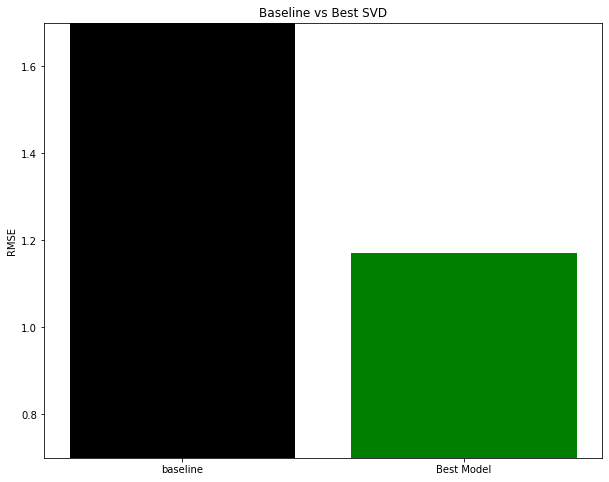

In [133]:
baseline_model_rmse = accuracy.rmse(base_pred)
best_model_rmse = accuracy.rmse(SVD_pred_3)

x = ['baseline', 'Best Model']
y = [baseline_model_rmse, best_model_rmse]

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y, color=['Black', 'Green'])
plt.ylim(0.7, 1.7)
ax.set_title("Baseline vs Best SVD")
plt.ylabel('RMSE');
# plt.savefig('images/suprise_models_bar.png', dpi=300, bbox_inches='tight');

# Function

## Deployment

## metadata

!ls data


import gzip

vec_tfidf

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta_df = getDF('./data/meta_Video_Games.json.gz')